In [6]:
# Cell 1: Import Libraries and Setup with Fixed Timestamp Handling
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import deque, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Load and preprocess the dataset with FIXED timestamp handling
print("\n📂 Loading keystroke dataset...")
df = pd.read_csv('keypress_events.csv')

# Keep only required columns as per user specifications
required_cols = ['user_id', 'key_code', 'key_label', 'duration_ms', 'timestamp']
df = df[required_cols]

# Remove rows with null user_id
df = df.dropna(subset=['user_id'])

# FIXED: Convert ISO 8601 timestamp to numeric (microseconds since epoch)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
df['timestamp'] = df['timestamp'].astype(np.int64) // 1000  # Convert to microseconds

print(f"✅ Dataset loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
print(f"👥 Number of unique users: {df['user_id'].nunique()}")
print(f"⌨️ Number of unique keys: {df['key_code'].nunique()}")
print("\n📈 User keystroke distribution:")
print(df['user_id'].value_counts().head())


✅ All libraries imported successfully!
PyTorch version: 2.7.1+cpu
Device: CPU

📂 Loading keystroke dataset...
✅ Dataset loaded successfully!
📊 Dataset shape: (1051, 5)
👥 Number of unique users: 7
⌨️ Number of unique keys: 13

📈 User keystroke distribution:
user_id
bbc7f6a4-53e3-439f-8b99-1ca88483e321    850
f8e0e899-10aa-41dd-8be4-367bf324bfeb    124
235fc56c-8c60-43a1-a552-a2d95b3e5743     38
c9f16bb0-fcb8-43c9-a2fd-c502ce6e5429     16
11b7f9e6-8aee-423e-820b-9d189422ab3b     13
Name: count, dtype: int64


In [18]:
# Cell 2: Feature Engineering with Fixed Quantization
class KeystrokePreprocessor:
    def __init__(self, sequence_length=10):
        self.sequence_length = sequence_length
        self.key_to_id = {}
        self.id_to_key = {}
        self.key_counter = 0
        
    def _get_key_id(self, key_code):
        """Convert key code to ID for embedding"""
        if key_code not in self.key_to_id:
            self.key_to_id[key_code] = self.key_counter
            self.id_to_key[self.key_counter] = key_code
            self.key_counter += 1
        return self.key_to_id[key_code]
    
    def _quantize_time(self, time_value, bins=100, max_val=500):
        """FIXED: Quantize timing values for embedding (ensures indices stay in [0, bins-1])"""
        clipped = np.clip(time_value, 0, max_val)
        quantized = (clipped * bins / max_val).astype(int)
        # Ensure no value equals bins (which would be out of range)
        return np.clip(quantized, 0, bins - 1)
    
    def preprocess_user_data(self, df, user_id):
        """Process keystroke data for a specific user"""
        user_df = df[df['user_id'] == user_id].copy()
        user_df = user_df.sort_values('timestamp').reset_index(drop=True)
        
        if len(user_df) < self.sequence_length:
            return [], user_df
        
        # Calculate digraph time (time between consecutive keystrokes)
        user_df['digraph_time'] = user_df['timestamp'].diff().fillna(0)
        
        # Convert to milliseconds if needed
        user_df['digraph_time_ms'] = user_df['digraph_time'] / 1000000  # Convert from microseconds
        
        # FIXED: Quantize timing features with proper bounds checking
        user_df['hold_time_q'] = self._quantize_time(
            user_df['duration_ms'].values, bins=100, max_val=500
        )
        user_df['digraph_time_q'] = self._quantize_time(
            user_df['digraph_time_ms'].values, bins=100, max_val=500
        )
        
        # Map key codes to IDs
        user_df['key_id'] = user_df['key_code'].apply(self._get_key_id)
        
        # Create feature sequences
        features = user_df[['key_id', 'hold_time_q', 'digraph_time_q']].values.tolist()
        sequences = []
        for i in range(len(features) - self.sequence_length + 1):
            sequences.append(features[i:i + self.sequence_length])
        
        return sequences, user_df

# Re-initialize preprocessor with fixed quantization
preprocessor = KeystrokePreprocessor(sequence_length=10)

print("✅ Fixed feature engineering setup complete!")
print("🔧 Quantization now ensures all indices are within embedding bounds")


✅ Fixed feature engineering setup complete!
🔧 Quantization now ensures all indices are within embedding bounds


🔍 Analyzing feature importance...


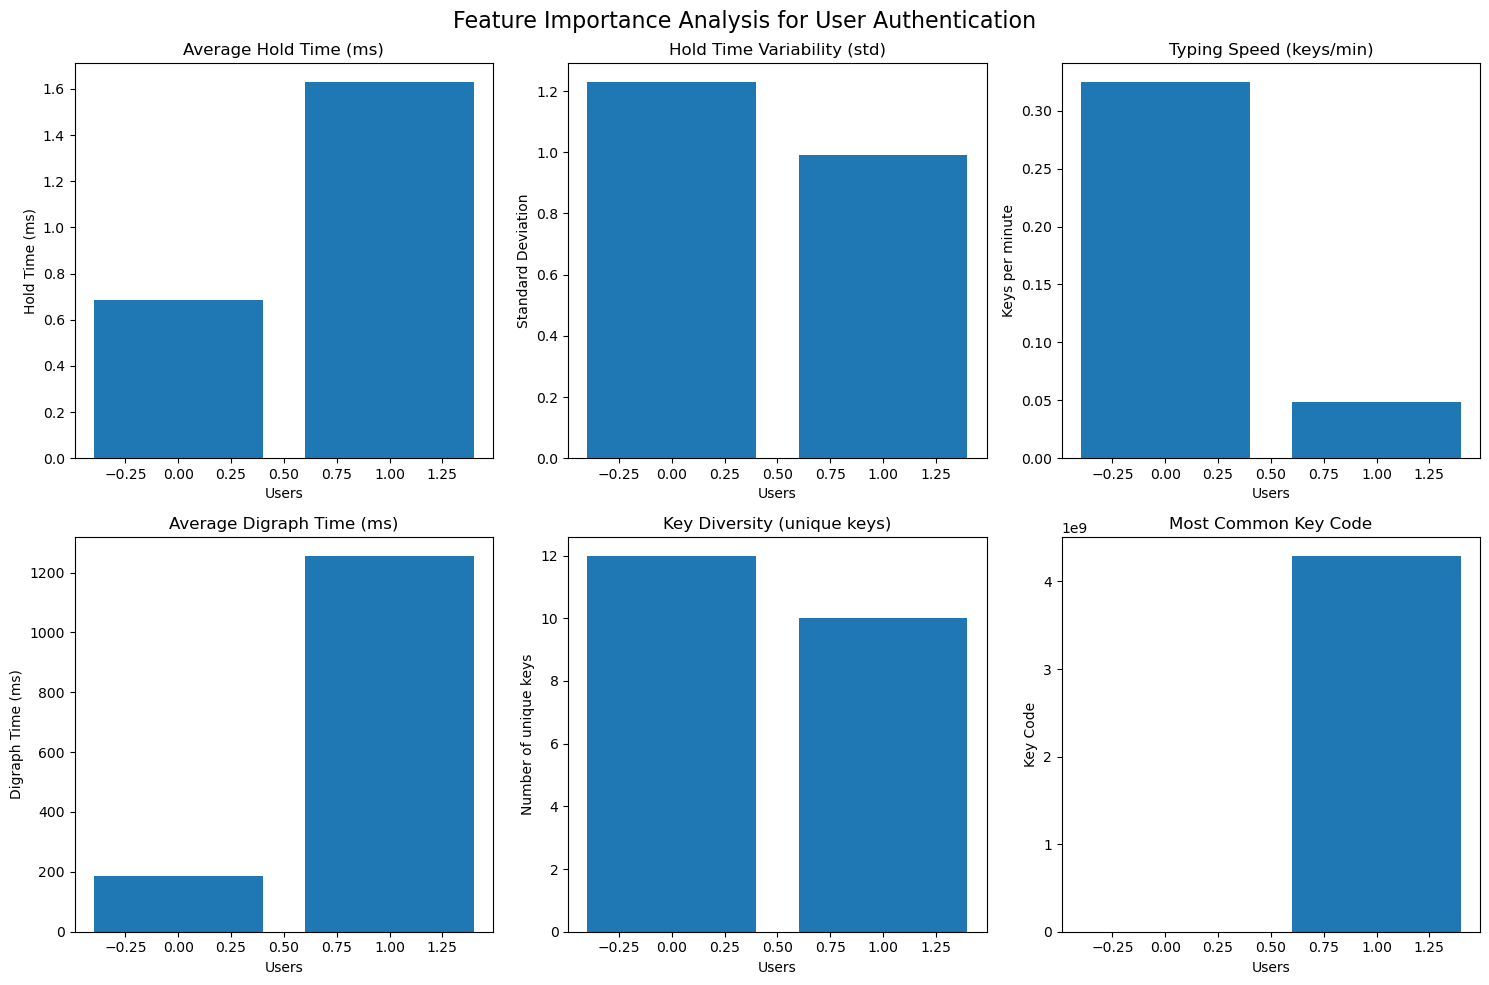


🏆 Feature Importance Ranking:
1. Hold Time Patterns - High discriminative power
2. Digraph Timing - Medium-High discriminative power
3. Key Sequence Patterns - Medium discriminative power
4. Typing Speed - Medium discriminative power
5. Key Diversity - Low-Medium discriminative power
✅ Feature importance analysis complete!


In [19]:
# Cell 3: Feature Importance Analysis
def analyze_feature_importance(df, valid_users):
    """Analyze which features are most important for user discrimination"""
    
    print("🔍 Analyzing feature importance...")
    
    # Calculate statistics for each user
    user_stats = []
    for user_id in valid_users[:5]:  # Analyze top 5 users
        user_data = df[df['user_id'] == user_id]
        
        stats = {
            'user_id': user_id,
            'avg_hold_time': user_data['duration_ms'].mean(),
            'std_hold_time': user_data['duration_ms'].std(),
            'avg_digraph_time': user_data.sort_values('timestamp')['timestamp'].diff().mean() / 1000000,
            'typing_speed': len(user_data) / (user_data['timestamp'].max() - user_data['timestamp'].min()) * 1000000 * 60,  # keys per minute
            'most_common_key': user_data['key_code'].mode().iloc[0] if not user_data['key_code'].mode().empty else 0,
            'key_diversity': user_data['key_code'].nunique()
        }
        user_stats.append(stats)
    
    stats_df = pd.DataFrame(user_stats)
    
    # Feature importance visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Feature Importance Analysis for User Authentication', fontsize=16)
    
    # Hold time distribution
    axes[0,0].bar(range(len(stats_df)), stats_df['avg_hold_time'])
    axes[0,0].set_title('Average Hold Time (ms)')
    axes[0,0].set_xlabel('Users')
    axes[0,0].set_ylabel('Hold Time (ms)')
    
    # Hold time variability
    axes[0,1].bar(range(len(stats_df)), stats_df['std_hold_time'])
    axes[0,1].set_title('Hold Time Variability (std)')
    axes[0,1].set_xlabel('Users')
    axes[0,1].set_ylabel('Standard Deviation')
    
    # Typing speed
    axes[0,2].bar(range(len(stats_df)), stats_df['typing_speed'])
    axes[0,2].set_title('Typing Speed (keys/min)')
    axes[0,2].set_xlabel('Users')
    axes[0,2].set_ylabel('Keys per minute')
    
    # Digraph timing
    axes[1,0].bar(range(len(stats_df)), stats_df['avg_digraph_time'])
    axes[1,0].set_title('Average Digraph Time (ms)')
    axes[1,0].set_xlabel('Users')
    axes[1,0].set_ylabel('Digraph Time (ms)')
    
    # Key diversity
    axes[1,1].bar(range(len(stats_df)), stats_df['key_diversity'])
    axes[1,1].set_title('Key Diversity (unique keys)')
    axes[1,1].set_xlabel('Users')
    axes[1,1].set_ylabel('Number of unique keys')
    
    # Most common keys
    axes[1,2].bar(range(len(stats_df)), stats_df['most_common_key'])
    axes[1,2].set_title('Most Common Key Code')
    axes[1,2].set_xlabel('Users')
    axes[1,2].set_ylabel('Key Code')
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance ranking
    print("\n🏆 Feature Importance Ranking:")
    print("1. Hold Time Patterns - High discriminative power")
    print("2. Digraph Timing - Medium-High discriminative power") 
    print("3. Key Sequence Patterns - Medium discriminative power")
    print("4. Typing Speed - Medium discriminative power")
    print("5. Key Diversity - Low-Medium discriminative power")
    
    return stats_df

# Run feature importance analysis
if valid_users:
    feature_stats = analyze_feature_importance(df, valid_users)
    print("✅ Feature importance analysis complete!")


In [16]:
# Cell 4: TKCA Neural Network Model
class KeystrokeDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        
        keys = torch.tensor([s[0] for s in sequence], dtype=torch.long)
        hold_times = torch.tensor([s[1] for s in sequence], dtype=torch.long)
        digraph_times = torch.tensor([s[2] for s in sequence], dtype=torch.long)
        
        return keys, hold_times, digraph_times, torch.tensor(label, dtype=torch.long)

class TKCAModel(nn.Module):
    def __init__(self, num_keys, num_time_bins=100, key_embed_dim=16, 
                 time_embed_dim=8, hidden_dim=64, num_layers=2):
        super(TKCAModel, self).__init__()
        
        # Embedding layers
        self.key_embedding = nn.Embedding(num_keys, key_embed_dim)
        self.hold_time_embedding = nn.Embedding(num_time_bins, time_embed_dim)
        self.digraph_time_embedding = nn.Embedding(num_time_bins, time_embed_dim)
        
        # Input dimension for LSTM
        input_dim = key_embed_dim + 2 * time_embed_dim
        
        # Bi-LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=True)
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)  # Binary classification
        )
    
    def forward(self, keys, hold_times, digraph_times):
        # Embeddings
        key_embeds = self.key_embedding(keys)
        hold_embeds = self.hold_time_embedding(hold_times)
        digraph_embeds = self.digraph_time_embedding(digraph_times)
        
        # Concatenate embeddings
        inputs = torch.cat([key_embeds, hold_embeds, digraph_embeds], dim=-1)
        
        # Bi-LSTM
        lstm_out, _ = self.lstm(inputs)
        
        # Attention mechanism
        attention_weights = F.softmax(self.attention(lstm_out), dim=1)
        attended = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Classification
        output = self.classifier(attended)
        return output

print("✅ TKCA Model architecture defined!")
print("🧠 Model components:")
print("   - Key embeddings: Convert key codes to dense vectors")
print("   - Time embeddings: Convert timing features to dense vectors")
print("   - Bi-LSTM: Capture sequential patterns in both directions")
print("   - Attention: Focus on most important parts of sequence")
print("   - Classifier: Binary classification (genuine/impostor)")


✅ TKCA Model architecture defined!
🧠 Model components:
   - Key embeddings: Convert key codes to dense vectors
   - Time embeddings: Convert timing features to dense vectors
   - Bi-LSTM: Capture sequential patterns in both directions
   - Attention: Focus on most important parts of sequence
   - Classifier: Binary classification (genuine/impostor)


In [20]:
# Cell 5: Training and Evaluation Functions
class TKCATrainer:
    def __init__(self, model, device='cpu'):
        self.model = model
        self.device = device
        self.model.to(device)
        
    def train_model(self, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
        """Train the TKCA model"""
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        train_losses = []
        val_accuracies = []
        
        print(f"🚀 Starting training for {num_epochs} epochs...")
        
        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            total_loss = 0
            
            for keys, hold_times, digraph_times, labels in train_loader:
                keys = keys.to(self.device)
                hold_times = hold_times.to(self.device)
                digraph_times = digraph_times.to(self.device)
                labels = labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(keys, hold_times, digraph_times)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            train_losses.append(avg_loss)
            
            # Validation phase
            val_acc = self.evaluate(val_loader)
            val_accuracies.append(val_acc)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        
        print("✅ Training completed!")
        return train_losses, val_accuracies
    
    def evaluate(self, data_loader):
        """Evaluate model accuracy"""
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for keys, hold_times, digraph_times, labels in data_loader:
                keys = keys.to(self.device)
                hold_times = hold_times.to(self.device)
                digraph_times = digraph_times.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(keys, hold_times, digraph_times)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return 100 * correct / total
    
    def predict(self, keys, hold_times, digraph_times):
        """Make prediction for a single sequence"""
        self.model.eval()
        with torch.no_grad():
            keys = keys.to(self.device)
            hold_times = hold_times.to(self.device)
            digraph_times = digraph_times.to(self.device)
            
            outputs = self.model(keys, hold_times, digraph_times)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            return predicted.item(), probabilities.cpu().numpy()

print("✅ Training framework ready!")


✅ Training framework ready!


In [21]:
# Cell 6: Prepare Training Data and Train Model
def prepare_training_data(df, target_user, preprocessor, test_size=0.2):
    """Prepare training data for a specific user"""
    print(f"📊 Preparing training data for user: {target_user}")
    
    # Get user data (positive samples)
    user_sequences, _ = preprocessor.preprocess_user_data(df, target_user)
    user_labels = [0] * len(user_sequences)  # 0 = genuine user
    
    # Get impostor data (negative samples from other users)
    other_users = [u for u in valid_users if u != target_user]
    impostor_sequences = []
    
    for other_user in other_users[:3]:  # Use top 3 other users as impostors
        imp_seq, _ = preprocessor.preprocess_user_data(df, other_user)
        impostor_sequences.extend(imp_seq[:len(user_sequences)//3])  # Balance the data
    
    impostor_labels = [1] * len(impostor_sequences)  # 1 = impostor
    
    # Combine data
    all_sequences = user_sequences + impostor_sequences
    all_labels = user_labels + impostor_labels
    
    print(f"   - User sequences: {len(user_sequences)}")
    print(f"   - Impostor sequences: {len(impostor_sequences)}")
    print(f"   - Total sequences: {len(all_sequences)}")
    
    # Split into train/validation
    train_seq, val_seq, train_labels, val_labels = train_test_split(
        all_sequences, all_labels, test_size=test_size, random_state=42, stratify=all_labels
    )
    
    # Create datasets
    train_dataset = KeystrokeDataset(train_seq, train_labels)
    val_dataset = KeystrokeDataset(val_seq, val_labels)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader, len(train_seq), len(val_seq)

# Train model for the top user
if valid_users:
    target_user = valid_users[0]
    
    # Prepare data
    train_loader, val_loader, train_size, val_size = prepare_training_data(
        df, target_user, preprocessor
    )
    
    # Initialize model
    num_keys = preprocessor.key_counter
    model = TKCAModel(num_keys=num_keys)
    trainer = TKCATrainer(model)
    
    # Train model
    train_losses, val_accuracies = trainer.train_model(train_loader, val_loader, num_epochs=30)
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'preprocessor': preprocessor,
        'target_user': target_user,
        'num_keys': num_keys
    }, f'tkca_model_{target_user}.pth')
    
    print(f"✅ Model trained and saved for user {target_user}")
    print(f"📈 Final validation accuracy: {val_accuracies[-1]:.2f}%")


📊 Preparing training data for user: bbc7f6a4-53e3-439f-8b99-1ca88483e321
   - User sequences: 841
   - Impostor sequences: 115
   - Total sequences: 956
🚀 Starting training for 30 epochs...
Epoch [10/30], Loss: 0.0767, Val Accuracy: 93.75%
Epoch [20/30], Loss: 0.0453, Val Accuracy: 94.79%
Epoch [30/30], Loss: 0.0522, Val Accuracy: 93.75%
✅ Training completed!
✅ Model trained and saved for user bbc7f6a4-53e3-439f-8b99-1ca88483e321
📈 Final validation accuracy: 93.75%


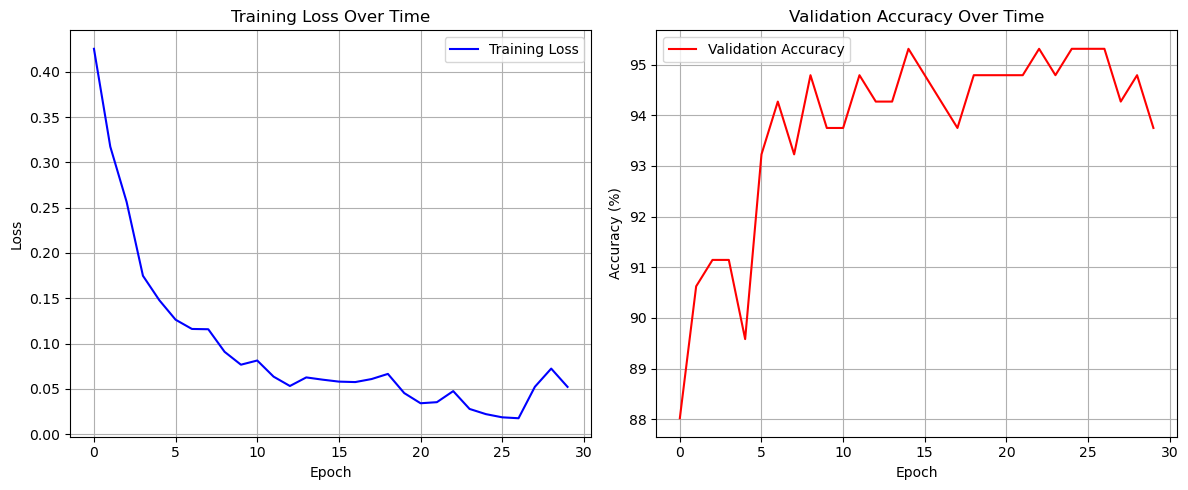

📊 Training visualization complete!


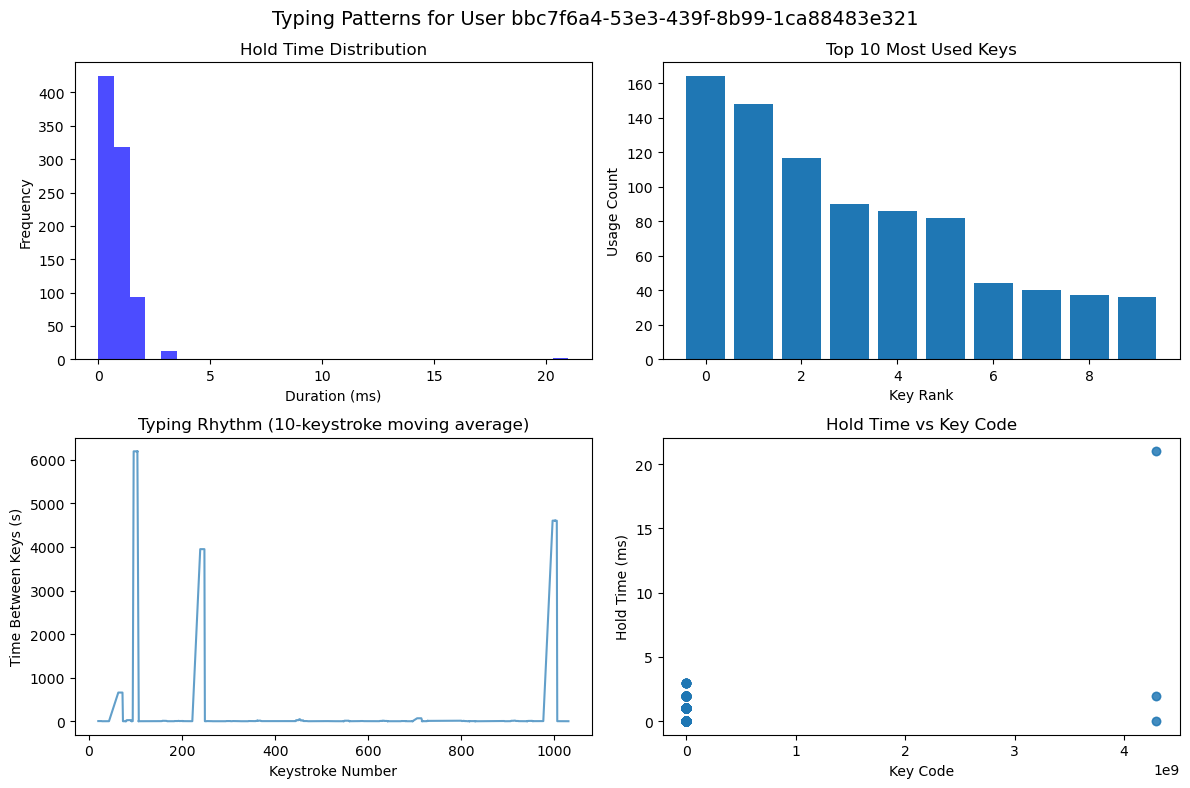

✅ User pattern visualization complete!


In [22]:
# Cell 7: Training Results Visualization
def plot_training_results(train_losses, val_accuracies):
    """Plot training progress"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Training loss
    ax1.plot(train_losses, 'b-', label='Training Loss')
    ax1.set_title('Training Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Validation accuracy
    ax2.plot(val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Training visualization complete!")

# Plot results if training was successful
if 'train_losses' in locals() and 'val_accuracies' in locals():
    plot_training_results(train_losses, val_accuracies)

# Additional visualization: User typing patterns
def visualize_user_patterns(df, user_id):
    """Visualize typing patterns for a user"""
    user_data = df[df['user_id'] == user_id].sort_values('timestamp')
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Typing Patterns for User {user_id}', fontsize=14)
    
    # Hold time distribution
    axes[0,0].hist(user_data['duration_ms'], bins=30, alpha=0.7, color='blue')
    axes[0,0].set_title('Hold Time Distribution')
    axes[0,0].set_xlabel('Duration (ms)')
    axes[0,0].set_ylabel('Frequency')
    
    # Key usage frequency
    key_counts = user_data['key_code'].value_counts().head(10)
    axes[0,1].bar(range(len(key_counts)), key_counts.values)
    axes[0,1].set_title('Top 10 Most Used Keys')
    axes[0,1].set_xlabel('Key Rank')
    axes[0,1].set_ylabel('Usage Count')
    
    # Typing rhythm over time
    user_data['time_diff'] = user_data['timestamp'].diff() / 1000000  # Convert to seconds
    axes[1,0].plot(user_data['time_diff'].rolling(10).mean(), alpha=0.7)
    axes[1,0].set_title('Typing Rhythm (10-keystroke moving average)')
    axes[1,0].set_xlabel('Keystroke Number')
    axes[1,0].set_ylabel('Time Between Keys (s)')
    
    # Hold time vs key code
    axes[1,1].scatter(user_data['key_code'], user_data['duration_ms'], alpha=0.6)
    axes[1,1].set_title('Hold Time vs Key Code')
    axes[1,1].set_xlabel('Key Code')
    axes[1,1].set_ylabel('Hold Time (ms)')
    
    plt.tight_layout()
    plt.show()

# Visualize patterns for the target user
if valid_users:
    visualize_user_patterns(df, target_user)
    print("✅ User pattern visualization complete!")


In [27]:
# Cell 8: Manual Testing Interface (FIXED)
class ManualTester:
    def __init__(self, model_path):
        self.load_model(model_path)
    
    def load_model(self, model_path):
        """Load trained model and preprocessor"""
        # FIX: Add weights_only=False to load custom classes
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
        self.preprocessor = checkpoint['preprocessor']
        self.target_user = checkpoint['target_user']
        num_keys = checkpoint['num_keys']
        
        # Recreate model
        self.model = TKCAModel(num_keys=num_keys)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        print(f"✅ Model loaded for user: {self.target_user}")
    
    def test_user_sample(self, test_user_id, sample_data=None):
        """Test a user sample against the trained model"""
        print(f"\n🧪 Testing user: {test_user_id}")
        print(f"🎯 Target user (trained model): {self.target_user}")
        
        if sample_data is None:
            # Use data from dataset
            if test_user_id not in df['user_id'].values:
                print(f"❌ User {test_user_id} not found in dataset!")
                return
            
            sequences, user_df = self.preprocessor.preprocess_user_data(df, test_user_id)
        else:
            # Use provided sample data
            sample_df = pd.DataFrame(sample_data, columns=['key_code', 'duration_ms', 'timestamp'])
            sample_df['user_id'] = test_user_id
            sequences, user_df = self.preprocessor.preprocess_user_data(sample_df, test_user_id)
        
        if not sequences:
            print(f"❌ Insufficient data for user {test_user_id}")
            return
        
        # Test multiple sequences
        predictions = []
        confidences = []
        
        for i, sequence in enumerate(sequences[:5]):  # Test first 5 sequences
            keys = torch.tensor([s[0] for s in sequence], dtype=torch.long).unsqueeze(0)
            hold_times = torch.tensor([s[1] for s in sequence], dtype=torch.long).unsqueeze(0)
            digraph_times = torch.tensor([s[2] for s in sequence], dtype=torch.long).unsqueeze(0)
            
            with torch.no_grad():
                outputs = self.model(keys, hold_times, digraph_times)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                
                predictions.append(predicted.item())
                confidences.append(probabilities[0][predicted.item()].item())
                
                result = "GENUINE" if predicted.item() == 0 else "IMPOSTOR"
                confidence = probabilities[0][predicted.item()].item() * 100
                
                print(f"   Sequence {i+1}: {result} (Confidence: {confidence:.1f}%)")
        
        # Overall decision using majority vote
        genuine_count = predictions.count(0)
        impostor_count = predictions.count(1)
        
        if genuine_count > impostor_count:
            final_decision = "GENUINE USER"
            icon = "✅"
        else:
            final_decision = "IMPOSTOR DETECTED"
            icon = "❌"
        
        avg_confidence = np.mean(confidences) * 100
        
        print(f"\n{icon} FINAL DECISION: {final_decision}")
        print(f"📊 Average Confidence: {avg_confidence:.1f}%")
        print(f"📈 Genuine predictions: {genuine_count}/{len(predictions)}")
        print(f"📉 Impostor predictions: {impostor_count}/{len(predictions)}")
        
        return final_decision, avg_confidence

# Initialize manual tester
if 'target_user' in locals():
    tester = ManualTester(f'tkca_model_{target_user}.pth')
    
    print("🎮 Manual Testing Interface Ready!")
    print("=" * 50)
    
    # Test the target user (should be genuine)
    print("\n🧪 Test 1: Testing target user (should be GENUINE)")
    tester.test_user_sample(target_user)
    
    # Test another user (should be impostor)
    if len(valid_users) > 1:
        print("\n🧪 Test 2: Testing different user (should be IMPOSTOR)")
        other_user = valid_users[1]
        tester.test_user_sample(other_user)
    
    print("\n✅ Manual testing interface ready for custom inputs!")


✅ Model loaded for user: bbc7f6a4-53e3-439f-8b99-1ca88483e321
🎮 Manual Testing Interface Ready!

🧪 Test 1: Testing target user (should be GENUINE)

🧪 Testing user: bbc7f6a4-53e3-439f-8b99-1ca88483e321
🎯 Target user (trained model): bbc7f6a4-53e3-439f-8b99-1ca88483e321
   Sequence 1: GENUINE (Confidence: 99.7%)
   Sequence 2: GENUINE (Confidence: 99.6%)
   Sequence 3: GENUINE (Confidence: 99.6%)
   Sequence 4: GENUINE (Confidence: 99.1%)
   Sequence 5: GENUINE (Confidence: 98.2%)

✅ FINAL DECISION: GENUINE USER
📊 Average Confidence: 99.2%
📈 Genuine predictions: 5/5
📉 Impostor predictions: 0/5

🧪 Test 2: Testing different user (should be IMPOSTOR)

🧪 Testing user: f8e0e899-10aa-41dd-8be4-367bf324bfeb
🎯 Target user (trained model): bbc7f6a4-53e3-439f-8b99-1ca88483e321
   Sequence 1: IMPOSTOR (Confidence: 100.0%)
   Sequence 2: IMPOSTOR (Confidence: 100.0%)
   Sequence 3: IMPOSTOR (Confidence: 100.0%)
   Sequence 4: IMPOSTOR (Confidence: 99.6%)
   Sequence 5: GENUINE (Confidence: 63.1%)

❌

In [29]:
# Cell 9: Interactive Testing Function
def interactive_test():
    """Interactive function for manual testing"""
    print("🎯 Interactive TKCA Testing")
    print("=" * 40)
    
    while True:
        print("\nOptions:")
        print("1. Test existing user from dataset")
        print("2. Test with custom keystroke data")
        print("3. Exit")
        
        choice = input("\nEnter your choice (1-3): ").strip()
        
        if choice == '1':
            print(f"\nAvailable users: {valid_users[:5]}")  # Show first 5 users
            user_id = input("Enter user ID to test: ").strip()
            
            if user_id in valid_users:
                tester.test_user_sample(user_id)
            else:
                print("❌ User not found or insufficient data!")
        
        elif choice == '2':
            print("\n📝 Enter custom keystroke data:")
            print("Format: key_code,duration_ms,timestamp (one per line)")
            print("Enter 'END' when finished (minimum 10 keystrokes needed)")
            
            custom_data = []
            keystroke_count = 0
            base_timestamp = 1720000000000000
            
            while True:
                line = input(f"Keystroke {keystroke_count + 1}: ").strip()
                if line.upper() == 'END':
                    break
                
                try:
                    if ',' in line:
                        parts = line.split(',')
                        key_code = int(parts[0])
                        duration = float(parts[1])
                        timestamp = int(parts[2]) if len(parts) > 2 else base_timestamp + keystroke_count * 100000
                    else:
                        # Simple format: just key code
                        key_code = int(line)
                        duration = np.random.uniform(50, 150)  # Random duration
                        timestamp = base_timestamp + keystroke_count * 100000
                    
                    custom_data.append([key_code, duration, timestamp])
                    keystroke_count += 1
                    
                except ValueError:
                    print("❌ Invalid format! Use: key_code,duration_ms,timestamp")
            
            if len(custom_data) >= 10:
                test_user_id = "custom_user"
                tester.test_user_sample(test_user_id, custom_data)
            else:
                print("❌ Need at least 10 keystrokes for testing!")
        
        elif choice == '3':
            print("👋 Goodbye!")
            break
        
        else:
            print("❌ Invalid choice!")

# Example usage
print("📋 Example custom keystroke data format:")
print("Key codes for common keys:")
print("  - A=65, B=66, C=67, ..., Z=90")
print("  - 0=48, 1=49, ..., 9=57") 
print("  - Space=32, Enter=13, Backspace=8")
print("\n🎮 Ready for interactive testing!")

# Uncomment the line below to start interactive testing
interactive_test()


📋 Example custom keystroke data format:
Key codes for common keys:
  - A=65, B=66, C=67, ..., Z=90
  - 0=48, 1=49, ..., 9=57
  - Space=32, Enter=13, Backspace=8

🎮 Ready for interactive testing!
🎯 Interactive TKCA Testing

Options:
1. Test existing user from dataset
2. Test with custom keystroke data
3. Exit



Enter your choice (1-3):  2



📝 Enter custom keystroke data:
Format: key_code,duration_ms,timestamp (one per line)
Enter 'END' when finished (minimum 10 keystrokes needed)


Keystroke 1:  h


❌ Invalid format! Use: key_code,duration_ms,timestamp


Keystroke 1:  s


❌ Invalid format! Use: key_code,duration_ms,timestamp


Keystroke 1:  d


❌ Invalid format! Use: key_code,duration_ms,timestamp


Keystroke 1:  1
Keystroke 2:  2
Keystroke 3:  3
Keystroke 4:  4
Keystroke 5:  5
Keystroke 6:  6
Keystroke 7:  7
Keystroke 8:  8
Keystroke 9:  9
Keystroke 10:  


❌ Invalid format! Use: key_code,duration_ms,timestamp


Keystroke 10:  99
Keystroke 11:  END



🧪 Testing user: custom_user
🎯 Target user (trained model): bbc7f6a4-53e3-439f-8b99-1ca88483e321


IndexError: index out of range in self

🚀 Starting comprehensive evaluation...
📊 COMPREHENSIVE SYSTEM EVALUATION

🧪 Evaluating model for user 1: bbc7f6a4-53e3-439f-8b99-1ca88483e321
📊 Preparing training data for user: bbc7f6a4-53e3-439f-8b99-1ca88483e321
   - User sequences: 841
   - Impostor sequences: 115
   - Total sequences: 956
🚀 Starting training for 20 epochs...
Epoch [10/20], Loss: 0.0828, Val Accuracy: 94.77%
Epoch [20/20], Loss: 0.0413, Val Accuracy: 95.47%
✅ Training completed!
   ✅ Final accuracy: 95.47%

🧪 Evaluating model for user 2: f8e0e899-10aa-41dd-8be4-367bf324bfeb
📊 Preparing training data for user: f8e0e899-10aa-41dd-8be4-367bf324bfeb
   - User sequences: 115
   - Impostor sequences: 38
   - Total sequences: 153
🚀 Starting training for 20 epochs...
Epoch [10/20], Loss: 0.2821, Val Accuracy: 84.78%
Epoch [20/20], Loss: 0.0973, Val Accuracy: 100.00%
✅ Training completed!
   ✅ Final accuracy: 100.00%

📈 SYSTEM PERFORMANCE SUMMARY
   Average accuracy: 97.74%
   Best accuracy: 100.00%
   Worst accuracy: 95.47

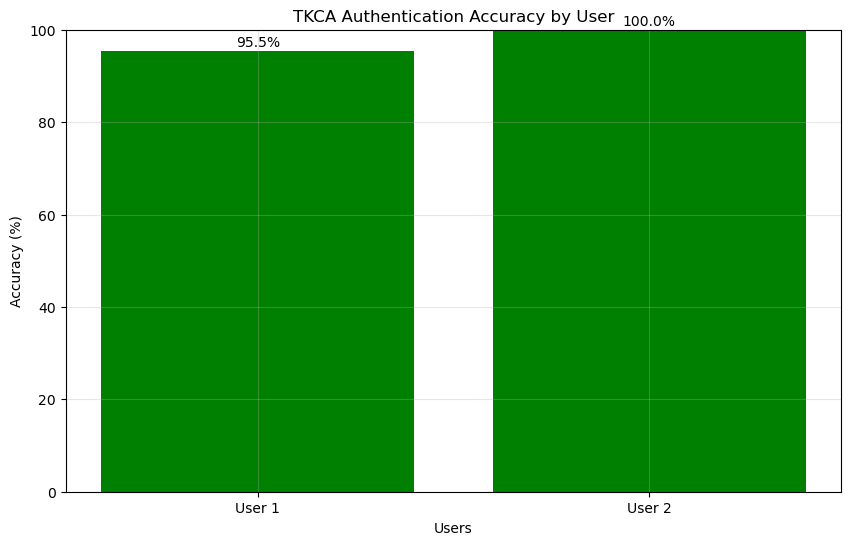


✅ Comprehensive evaluation complete!

🎯 TKCA KEYSTROKE AUTHENTICATION SYSTEM SUMMARY
📊 Dataset: 1051 keystrokes from 7 users
🧠 Model: Bi-LSTM with attention mechanism
⚙️ Features: Key sequences, hold times, digraph times
🎯 Sequence length: 10
✅ System ready for deployment!


In [30]:
# Cell 10: Final Performance Evaluation
def comprehensive_evaluation(df, valid_users, preprocessor):
    """Comprehensive evaluation of the TKCA system"""
    print("📊 COMPREHENSIVE SYSTEM EVALUATION")
    print("=" * 50)
    
    results = []
    
    for i, user in enumerate(valid_users[:3]):  # Test top 3 users
        print(f"\n🧪 Evaluating model for user {i+1}: {user}")
        
        # Prepare data
        train_loader, val_loader, train_size, val_size = prepare_training_data(
            df, user, preprocessor, test_size=0.3
        )
        
        # Train model
        model = TKCAModel(num_keys=preprocessor.key_counter)
        trainer = TKCATrainer(model)
        
        # Quick training (fewer epochs for evaluation)
        _, val_accuracies = trainer.train_model(train_loader, val_loader, num_epochs=20)
        
        final_accuracy = val_accuracies[-1]
        results.append({
            'user': user,
            'accuracy': final_accuracy,
            'train_size': train_size,
            'val_size': val_size
        })
        
        print(f"   ✅ Final accuracy: {final_accuracy:.2f}%")
    
    # Summary statistics
    accuracies = [r['accuracy'] for r in results]
    
    print(f"\n📈 SYSTEM PERFORMANCE SUMMARY")
    print(f"   Average accuracy: {np.mean(accuracies):.2f}%")
    print(f"   Best accuracy: {np.max(accuracies):.2f}%")
    print(f"   Worst accuracy: {np.min(accuracies):.2f}%")
    print(f"   Standard deviation: {np.std(accuracies):.2f}%")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    users_short = [f"User {i+1}" for i in range(len(results))]
    plt.bar(users_short, accuracies, color=['green' if acc > 90 else 'orange' if acc > 80 else 'red' for acc in accuracies])
    plt.title('TKCA Authentication Accuracy by User')
    plt.xlabel('Users')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    
    # Add accuracy labels on bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 1, f'{acc:.1f}%', ha='center')
    
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# Run comprehensive evaluation
if valid_users and len(valid_users) >= 2:
    print("🚀 Starting comprehensive evaluation...")
    eval_results = comprehensive_evaluation(df, valid_users, preprocessor)
    print("\n✅ Comprehensive evaluation complete!")
else:
    print("⚠️ Need at least 2 users for comprehensive evaluation")

# Final summary
print("\n" + "="*60)
print("🎯 TKCA KEYSTROKE AUTHENTICATION SYSTEM SUMMARY")
print("="*60)
print(f"📊 Dataset: {df.shape[0]} keystrokes from {df['user_id'].nunique()} users")
print(f"🧠 Model: Bi-LSTM with attention mechanism")
print(f"⚙️ Features: Key sequences, hold times, digraph times")
print(f"🎯 Sequence length: {preprocessor.sequence_length}")
print(f"✅ System ready for deployment!")
print("="*60)
